## Input

In [1]:
import geopandas as gpd

# Read the shapefile into a GeoDataFrame
df = gpd.read_file("../raw_data/gadm41_DEU_3.json")

In [2]:
df[['NAME_3','geometry']]

,NAME_3,geometry
0,Allmendingen,"MULTIPOLYGON (((9.82220 48.31950, 9.80970 48.3..."
1,Blaubeuren,"MULTIPOLYGON (((9.83130 48.45610, 9.83280 48.4..."
2,Blaustein,"MULTIPOLYGON (((9.82750 48.45700, 9.82610 48.4..."
3,Dietenheim,"MULTIPOLYGON (((10.08380 48.19700, 10.08570 48..."
4,Dornstadt,"MULTIPOLYGON (((9.90640 48.43220, 9.90400 48.4..."
...,...,...
4675,Grammetal,"MULTIPOLYGON (((11.26150 50.93760, 11.25890 50..."
4676,Ilmtal-Weinstraße,"MULTIPOLYGON (((11.39260 50.99050, 11.39070 50..."
4677,Kranichfeld,"MULTIPOLYGON (((11.21320 50.80440, 11.20630 50..."
4678,Mellingen,"MULTIPOLYGON (((11.49150 50.89630, 11.49600 50..."


In [4]:
Berlin_df = df[df['NAME_3']=='Berlin']
multipoly= Berlin_df['geometry']

In [7]:
multipoly

2028    MULTIPOLYGON (((13.50020 52.61380, 13.49680 52...
Name: geometry, dtype: geometry

In [10]:
multipoly_geom = multipoly.iloc[0]
type(multipoly_geom)

shapely.geometry.multipolygon.MultiPolygon

In [11]:
polygon = cascaded_union(multipoly)

/var/folders/11/qmf8fycd0_d7cflbxhz7fnfw0000gn/T/ipykernel_97364/2109251528.py:1: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  polygon = cascaded_union(multipoly)


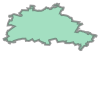

In [12]:
polygon

In [31]:
multipolygon_to_polygons(multipoly_geom)

[<POLYGON ((13.5 52.614, 13.497 52.605, 13.499 52.605, 13.508 52.592, 13.522 ...>]

In [30]:
from shapely.geometry import MultiPolygon, Polygon

def multipolygon_to_polygons(multipolygon):
    if not isinstance(multipolygon, MultiPolygon):
        raise ValueError('Input is not a MultiPolygon')
    
    polygons = []
    for polygon in multipolygon.geoms:
        if isinstance(polygon, Polygon):
            polygons.append(polygon)
        else:
            polygons.extend(polygon.geoms)
    return polygons

In [48]:
import requests
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import orient


def api_call_multipolygons(multipolygon, coord_uncertainty="500", year="2010,2023"):
    if not isinstance(multipolygon, MultiPolygon):
        raise ValueError('Input is not a MultiPolygon')

    polygons = []
    for polygon in multipolygon.geoms:
        if isinstance(polygon, Polygon):
            polygons.append(polygon)
        else:
            polygons.extend(polygon.geoms)

    all_coordinates = []
    for polygon in polygons:
        poly = orient(polygon, sign=1.0)

        # Calculate the bounding box coordinates from the polygon
        min_lat, min_lon, max_lat, max_lon = poly.bounds

        # Set the query parameters to retrieve occurrences within the polygon and bounding box
        params = {
            "geometry": poly.wkt,  # Polygon coordinates in counterclockwise order
            "decimalLongitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
            "decimalLatitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
            "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
            "limit": 300,  # Maximum number of occurrences to download per batch
            "offset": 0,  # Offset for paginating through results
            "year": year,  # Filter occurrences by year
            # Add any other relevant query parameters here
        }
        # Make multiple requests with different offset values to retrieve all occurrences
        all_results = []
        while True:
            response = requests.get("https://api.gbif.org/v1/occurrence/search", params=params)
            try:
                response.raise_for_status()
                response_json = response.json()
            except requests.exceptions.RequestException as e:
                print(f"Request error: {e}")
                return None
            except ValueError as e:
                print(f"JSON decode error: {e}")
                print(f"Response content: {response.content}")
                return None

            results = response_json["results"]
            if len(results) == 0:
                break
            all_results.extend(results)
            params["offset"] += 300

        # Extract the coordinates from the results
        coordinates = []
        for result in all_results:
            if "decimalLatitude" in result and "decimalLongitude" in result:
                coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

        all_coordinates.append(coordinates)
    return all_coordinates

In [49]:
api_call_multipolygons(multipoly_geom)

[[(52.545699, 13.353909),
  (52.468468, 13.554884),
  (52.549299, 13.337297),
  (52.55399, 13.167635),
  (52.492581, 13.310927),
  (52.525909, 13.446264),
  (52.531825, 13.611667),
  (52.531825, 13.611667),
  (52.510481, 13.370915),
  (52.509865, 13.35853),
  (52.523915, 13.289092),
  (52.478947, 13.482519),
  (52.538187, 13.428128),
  (52.538187, 13.428128),
  (52.54118, 13.425734),
  (52.54118, 13.425734),
  (52.537985, 13.435777),
  (52.537985, 13.435777),
  (52.537985, 13.435777),
  (52.537985, 13.435777),
  (52.550949, 13.496973),
  (52.550949, 13.496973),
  (52.550949, 13.496973),
  (52.509098, 13.350421),
  (52.506462, 13.367488),
  (52.514607, 13.572952),
  (52.534906, 13.453627),
  (52.515293, 13.370384),
  (52.519468, 13.399039),
  (52.503532, 13.348652),
  (52.503532, 13.348652),
  (52.503532, 13.348652),
  (52.503532, 13.348652),
  (52.50507, 13.520682),
  (52.51477, 13.351275),
  (52.493588, 13.349562),
  (52.548827, 13.341418),
  (52.552072, 13.381241),
  (52.54758, 13.33

In [32]:
polygon = multipolygon_to_polygon(multipoly_geom)

ValueError: Input must be a Polygon or MultiPolygon object

In [175]:
type(polygon)

In [173]:
import requests
from shapely.geometry import Polygon

def api_call(polygon, coord_uncertainty="500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"
    
    poly = orient(polygon, sign=1.0)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = poly.bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": poly.wkt,  # Polygon coordinates in counterclockwise order
        "decimalLongitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLatitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }
    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        try:
            response.raise_for_status()
            response_json = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return None
        except ValueError as e:
            print(f"JSON decode error: {e}")
            print(f"Response content: {response.content}")
            return None

        results = response_json["results"]
        if len(results) == 0:
            break
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [174]:
api_call(polygon)

In [73]:
from pyproj import CRS
from shapely.ops import orient

def api_call(multipolygon, coord_uncertainty="500", year="2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Merge the polygons into a single Polygon object
    poly = cascaded_union(multipolygon)

    # Simplify the resulting Polygon object
    #poly = polygon.buffer(0).simplify(0.001)
    poly = orient(polygon, sign=1.0)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = poly.bounds

    # Set the CRS
    crs = CRS("EPSG:4326")

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": poly.wkt,  # Polygon coordinates in counterclockwise order
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        response_json = response.json()
        results = response_json["results"]
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [74]:
api_call(multipoly)

/var/folders/11/qmf8fycd0_d7cflbxhz7fnfw0000gn/T/ipykernel_81012/4106546738.py:9: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(multipolygon)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [66]:
import requests
import geopandas as gpd
from shapely.geometry import Polygon

def api_call(multipolygon, coord_uncertainty="0,500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Convert the MultiPolygon to a GeoDataFrame and explode it into a DataFrame with one row per Polygon
    gdf = gpd.GeoDataFrame(geometry=[multipolygon])
    gdf = gdf.explode(index_parts=True).reset_index(drop=True)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = gdf.total_bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": f"POLYGON(({gdf.iloc[0].geometry.wkt}))",  # Polygon coordinates in counterclockwise order
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        response_json = response.json()
        results = response_json["results"]
        if len(results) == 0:
            break
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [68]:
api_call(multipoly)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [42]:
    # Convert the MultiPolygon to a GeoSeries and explode it into separate Polygon objects
geo_series = gpd.GeoSeries(multipoly)
polygons = geo_series.explode()

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [38]:
gdf = gdf.explode(index_parts=True).reset_index(drop=True)
    # Calculate the bounding box coordinates from the polygon
min_lat, min_lon, max_lat, max_lon = gdf.total_bounds

In [ ]:
new_df.iloc[0]['geometry']

In [ ]:
from shapely.ops import orient
counterclockwise_polygon = orient(polygon, sign=1.0)

In [ ]:
counterclockwise_polygon

In [ ]:
oly_counterclock = orient(poly, sign=1.0)

In [ ]:
minx, miny, maxx, maxy = counterclockwise_polygon.bounds
minx

In [ ]:
print(miny)

In [ ]:
maxx

In [ ]:
maxy

## API request

In [ ]:
import requests
url = "https://api.gbif.org/v1/occurrence/search"

If you specify both the bounding box parameters (decimalLatitude and decimalLongitude) and the polygon geometry parameter in your GBIF API query, the API will apply both filters to the results. Specifically, the API will return only those occurrences that fall within both the bounding box and the polygon.

This means that if an occurrence falls within the bounding box but outside the polygon, it will be excluded from the results. Similarly, if an occurrence falls within the polygon but outside the bounding box, it will also be excluded from the results.

In [ ]:
params = {
    "decimalLatitude": f"{miny},{maxy}",
    "decimalLongitude": f"{minx},{maxx}",
    "limit": 300,  # Maximum number of occurrences to download per batch
    "offset":0,
    "geometry": counterclockwise_polygon, # or "bbox" for a bounding box
    "year": "2010,2023",
    "coordinateUncertaintyInMeters": "0,500"
    # add any other relevant query parameters here
}

In [9]:
import requests
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union
def api_call(multipolygon, coord_uncertainty="0,500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Merge the polygons into a single Polygon object
    poly = cascaded_union(multipolygon)
    
    #orienting polygon counterclockwise
    poly_counterclock = orient(poly, sign=1.0)

    # Simplify the resulting Polygon object
    poly_simplified = poly_counterclock.buffer(0).simplify(0.001)

    # Calculate the bounding box coordinates afrom the polygon
    min_lat, min_lon, max_lat, max_lon = poly_simplified.bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": poly_simplified,  # Polygon coordinates in counterclockwise order
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        response_json = response.json()
        results = response_json["results"]
        if len(results) == 0:
            break
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [67]:
import requests
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union

def api_call(multipolygon, coord_uncertainty="0,500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Merge the polygons into a single Polygon object
    poly = cascaded_union(multipolygon)
    # Merge the polygons into a single Polygon object
    poly = poly.buffer(0).simplify(0.001)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = poly.bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": poly,  # Polygon coordinates in counterclockwise order
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        response_json = response.json()
        results = response_json["results"]
        if len(results) == 0:
            break
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [86]:
    url = "https://api.gbif.org/v1/occurrence/search"

    # Merge the polygons into a single Polygon object
    poly = cascaded_union(multipoly)
    # Merge the polygons into a single Polygon object
   # poly = poly.buffer(0).simplify(0.001)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = poly.bounds

/var/folders/11/qmf8fycd0_d7cflbxhz7fnfw0000gn/T/ipykernel_77324/1294787810.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(multipoly)


In [90]:
min_lat

13.0883

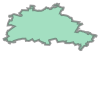

In [87]:
poly

In [91]:
url = "https://api.gbif.org/v1/occurrence/search"
params = {
        "geometry": poly,  # Polygon coordinates in WKT format
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        #"coordinateUncertaintyInMeters":500 ,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        #"year": "2010,2023",  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

In [92]:
response = requests.get(url, params=params)
response_json = response.json()
response_json['results']

[]

In [41]:
import requests
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import cascaded_union

def api_call(multipolygon, coord_uncertainty="0,500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Merge the polygons into a single Polygon object
    poly = cascaded_union(multipolygon)

    # Simplify the resulting Polygon object
    poly = poly.buffer(0).simplify(0.001)

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = poly.bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": poly.wkt,  # Polygon coordinates in WKT format
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            response_json = response.json()
            results = response_json["results"]
            if len(results) == 0:
                break
            all_results.extend(results)
            params["offset"] += 300
        except requests.exceptions.RequestException as e:
            print(f"Request error: {e}")
            return None
        except KeyError as e:
            print(f"Key error: {e}")
            return None
        except ValueError as e:
            print(f"Value error: {e}")
            return None

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates


In [10]:
import requests
import geopandas as gpd
from shapely.geometry import Polygon

def api_call(multipolygon, coord_uncertainty="0,500", year="2010,2023"):
    # Set the endpoint URL
    url = "https://api.gbif.org/v1/occurrence/search"

    # Convert the MultiPolygon to a GeoDataFrame and explode it into a DataFrame with one row per Polygon
    gdf = gpd.GeoDataFrame(geometry=[multipolygon])
    gdf = gdf.explode()

    # Calculate the bounding box coordinates from the polygon
    min_lat, min_lon, max_lat, max_lon = gdf.total_bounds

    # Set the query parameters to retrieve occurrences within the polygon and bounding box
    params = {
        "geometry": f"POLYGON(({gdf.iloc[0].geometry.wkt}))",  # Polygon coordinates in counterclockwise order
        "decimalLatitude": f"{min_lat},{max_lat}",  # Bounding box latitude range
        "decimalLongitude": f"{min_lon},{max_lon}",  # Bounding box longitude range
        "coordinateUncertaintyInMeters": coord_uncertainty,  # Filter occurrences by coordinate uncertainty
        "limit": 300,  # Maximum number of occurrences to download per batch
        "offset": 0,  # Offset for paginating through results
        "year": year,  # Filter occurrences by year
        # Add any other relevant query parameters here
    }

    # Make multiple requests with different offset values to retrieve all occurrences
    all_results = []
    while True:
        response = requests.get(url, params=params)
        response_json = response.json()
        results = response_json["results"]
        if len(results) == 0:
            break
        all_results.extend(results)
        params["offset"] += 300

    # Extract the coordinates from the results
    coordinates = []
    for result in all_results:
        if "decimalLatitude" in result and "decimalLongitude" in result:
            coordinates.append((result["decimalLatitude"], result["decimalLongitude"]))

    # Return the coordinates
    return coordinates

In [11]:
coordinate_list = api_call(multipoly)

/var/folders/11/qmf8fycd0_d7cflbxhz7fnfw0000gn/T/ipykernel_81012/3880336026.py:11: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gdf.explode()


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [101]:
coordinate_list

[]

In [59]:
type(multipoly)

NameError: name 'coordinates' is not defined

In [56]:
response.status_code

NameError: name 'response' is not defined

In [39]:
%%time
# Initialize a list to store the results
all_results = []

# Make multiple requests with different offset values to retrieve all occurrences
while True:
    response = requests.get(url, params=params)
    response_json = response.json()
    results = response_json["results"]
    if len(results) == 0:
        break
    all_results.extend(results)
    params["offset"] += 300

# Print the total number of occurrences retrieved
print(f"Total number of occurrences: {len(all_results)}")

KeyboardInterrupt: 

In [ ]:
#response = requests.get(url, params=params)

In [ ]:
# Print the URL that will be requested
full_url = f"{url}?{'&'.join(f'{k}={v}' for k, v in params.items())}"
print(f"Requesting {full_url}")

In [ ]:
# Print the response content or process it as a JSON object
if response.status_code == 200:
    response_json = response.json()
    results = response_json["results"]
    print(f"Found {len(results)} occurrences")
else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
response_json['results']

In [43]:
coordinates = [(r["decimalLatitude"], r["decimalLongitude"]) for r in results]

In [44]:
coordinates

[(52.519789, 13.586242),
 (52.516485, 13.586512),
 (52.516455, 13.586483),
 (52.516087, 13.585735),
 (52.515271, 13.583949),
 (52.51388, 13.581844),
 (52.513465, 13.578722),
 (52.546936, 13.384772),
 (52.511539, 13.399203),
 (52.582742, 13.364663),
 (52.420716, 13.377815),
 (52.492816, 13.321373),
 (52.492816, 13.321373),
 (52.492816, 13.321373),
 (52.492816, 13.321373),
 (52.492627, 13.320845),
 (52.492627, 13.320845),
 (52.492627, 13.320845),
 (52.492627, 13.320845),
 (52.492627, 13.320845),
 (52.492627, 13.320845),
 (52.492409, 13.320179),
 (52.492409, 13.320179),
 (52.492409, 13.320179),
 (52.492409, 13.320179),
 (52.492362, 13.318245),
 (52.492761, 13.316986),
 (52.492761, 13.316986),
 (52.492761, 13.316986),
 (52.493122, 13.315778),
 (52.493122, 13.315778),
 (52.493122, 13.315778),
 (52.493626, 13.314762),
 (52.493626, 13.314762),
 (52.493896, 13.314869),
 (52.494755, 13.315156),
 (52.494755, 13.315156),
 (52.495085, 13.315313),
 (52.49542, 13.315606),
 (52.49545, 13.315876),
 (5

In [45]:
species_list = [r["species"] for r in results]
basis_of_record_list = [r["basisOfRecord"] for r in results]

KeyError: 'species'

In [46]:
species_list

NameError: name 'species_list' is not defined